In [ ]:
!git clone https://github.com/Amoghmanoranjith/Multi-KWS 
!pip install vector-quantize-pytorch
%cd Multi-KWS

In [5]:
# stop
# %cd ..
# !rm -rf Multi-KWS

In [ ]:
# required libraries
import torch
import time
import random
import get_data
from torch import optim, nn
from torch.utils.data import DataLoader
from models import Res15, Decoder, Regularizer
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from vector_quantize_pytorch import ResidualVQ, VectorQuantize
from sklearn.metrics import accuracy_score as acc_fn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
train_data = get_data.SubsetSC(subset = "training")
test_data = get_data.SubsetSC(subset = "testing")
val_data = get_data.SubsetSC(subset = 'validation')

In [8]:
!pwd

/kaggle/working/Multi-KWS


In [4]:
classes = get_data.DEFAULT_LABELS
num_classes = len(classes)

In [5]:
train_loader = DataLoader(train_data,
                         batch_size=128,
                         shuffle=True,
                         collate_fn = get_data.collate_fn,
                         pin_memory = True,
                         num_workers = 4)
test_loader = DataLoader(test_data,
                         batch_size=128,
                         shuffle=True,
                         collate_fn = get_data.collate_fn,
                         pin_memory = True,
                        num_workers = 4)
val_loader = DataLoader(val_data,
                         batch_size=128,
                         shuffle=True,
                         collate_fn = get_data.collate_fn,
                         pin_memory = True,
                       num_workers = 4)

In [6]:
def train_step(encoder, decoder,reggy, op, loss_fn, loader, device):
    encoder.train()
    decoder.train()
    losses = 0
    accs = 0
    for batch, (X,y) in tqdm(enumerate(loader), total = len(loader)):
        X = X.to(device)
        y = y.to(device)
        embeds = encoder(X)
        embeds = reggy(embeds)
        logits = decoder(embeds)
        probs = torch.softmax(logits, dim = -1)
        preds = torch.argmax(probs, dim = -1)
        loss = loss_fn(logits, y)
        op.zero_grad()
        loss.backward()
        op.step()
        losses += loss.item()
        accs += torch.sum(preds == y).detach().cpu().numpy()
    losses /= len(loader)
    accs /= len(train_data)
    print(f"for training loss : {losses}, accuracy : {accs}")
    return losses, accs


def test_step(encoder, decoder,reggy, loss_fn, loader, device):
    encoder.eval()
    decoder.eval()
    with torch.inference_mode():
        losses = 0
        accs = 0
        for batch, (X,y) in tqdm(enumerate(loader), total = len(loader)):
            X = X.to(device)
            y = y.to(device)
            embeds = encoder(X)
            embeds = reggy(embeds)
            logits = decoder(embeds)
            probs = torch.softmax(logits, dim = -1)
            preds = torch.argmax(probs, dim = -1)
            loss = loss_fn(logits, y)
            losses += loss.item()
            accs += torch.sum(preds == y).detach().cpu().numpy()
        losses /= len(loader)
        accs /= len(val_data)
        print(f"for testing loss : {losses}, accuracy : {accs}")
        return losses, accs
    

In [9]:
len(val_data), len(test_data)

(9981, 11005)

In [7]:
encoder = Res15(inp = 1, n_maps = 45)
decoder = Decoder(num_classes, 45)
reggy = Regularizer()
encoder.to(device)
decoder.to(device)
reggy.to(device)
BATCH_SIZE = 128
LR = 0.01
op = optim.Adam(params = list(encoder.parameters()) + list(decoder.parameters()), lr = LR)
loss_fn = nn.CrossEntropyLoss()

In [8]:
op.state_dict()

{'state': {},
 'param_groups': [{'lr': 0.01,
   'betas': (0.9, 0.999),
   'eps': 1e-08,
   'weight_decay': 0,
   'amsgrad': False,
   'maximize': False,
   'foreach': None,
   'capturable': False,
   'differentiable': False,
   'fused': None,
   'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]}]}

In [15]:
X,y = next(iter(val_loader))
X[0].shape


torch.Size([1, 64, 63])

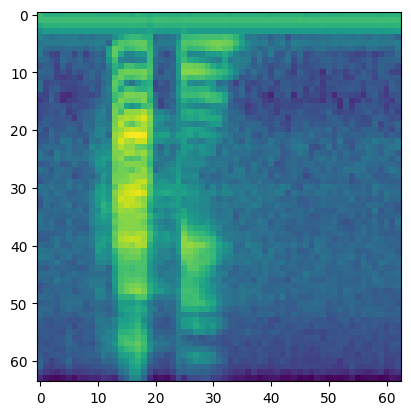

In [7]:
plt.imshow(X[0].squeeze())

In [29]:
len(test_loader)*128

11008

In [ ]:
EPOCHS = 30
train_losses = []
test_losses = []
start = time.time()
for e in tqdm(range(EPOCHS)):
    loss, acc = train_step(encoder, decoder, reggy, op, loss_fn, train_loader, device)
    train_losses.append(loss)
end = time.time()
print(f"took {end - start} seconds")

In [ ]:
with torch.inference_mode():
    plt.figure(figsize = (10,6))
    plt.plot(torch.tensor(train_losses).cpu(), c = 'b')
    plt.plot(torch.tensor(test_losses).cpu(), c = 'r')

In [ ]:
from pathlib import Path
m1 = Path('encoder40_45.pt')
m2 = Path('decoder40_45.pt')
torch.save(encoder.state_dict(), m1)
torch.save(decoder.state_dict(), m2)

In [35]:
keys = model.state_dict().keys()

In [ ]:
get_data._get_size(encoder)

In [11]:
encoder = Res15(n_maps = 45)
decoder = Decoder(num_classes, 45)
reggy = Regularizer()
encoder.to(device)
decoder.to(device)
reggy.to(device)
BATCH_SIZE = 128
LR = 0.01
op = optim.Adam(params = list(encoder.parameters()) + list(decoder.parameters()), lr = LR)
loss_fn = nn.CrossEntropyLoss()

In [13]:
EPOCHS = 10
train_losses = []
test_losses = []

In [21]:
start = time.time()
for e in tqdm(range(EPOCHS)):
    encoder.train()
    decoder.train()
    losses = 0
    accs = 0
    for batch, (X,y) in tqdm(enumerate(train_loader), total = len(train_loader)):
        X = X.to(device)
        y = y.to(device)
        embeds = encoder(X)
        embeds = reggy(embeds)
        logits = decoder(embeds)
        probs = torch.softmax(logits, dim = -1)
        preds = torch.argmax(probs, dim = -1)
        loss = loss_fn(logits, y)
        op.zero_grad()
        loss.backward()
        op.step()
        losses += loss
        accs += acc_fn(preds, y)
    losses /= len(train_loader)
    accs /= len(train_loader)
    print(f"for training loss : {losses}, accuracy : {accs}")
    train_losses.append(loss)


    encoder.eval()
    with torch.inference_mode():
        losses = 0
        accs = 0
        for batch, (X,y) in tqdm(enumerate(test_loader), total = len(test_loader)):
            X = X.to(device)
            y = y.to(device)
            embeds = encoder(X)
            embeds = reggy(embeds)
            logits = decoder(embeds)
            probs = torch.softmax(logits, dim = -1)
            preds = torch.argmax(probs, dim = -1)
            loss = loss_fn(logits, y)
            losses += loss
            accs += acc_fn(preds, y)
        losses /= len(test_loader)
        accs /= len(test_loader)
        print(f"for testing loss : {losses}, accuracy : {accs}")
        test_losses.append(loss)
end = time.time()
print(f"took {end - start} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/827 [00:00<?, ?it/s]

for training loss : 0.2200165092945099, accuracy : 93.2626724243164


  0%|          | 0/86 [00:00<?, ?it/s]

for testing loss : 0.09639344364404678, accuracy : 97.0199203491211


  0%|          | 0/827 [00:00<?, ?it/s]

for training loss : 0.2171776294708252, accuracy : 93.4642105102539


  0%|          | 0/86 [00:00<?, ?it/s]

for testing loss : 0.09928794950246811, accuracy : 96.97383880615234


  0%|          | 0/827 [00:00<?, ?it/s]

for training loss : 0.21082040667533875, accuracy : 93.56427764892578


  0%|          | 0/86 [00:00<?, ?it/s]

for testing loss : 0.09460902959108353, accuracy : 97.01969146728516


  0%|          | 0/827 [00:00<?, ?it/s]

for training loss : 0.20578177273273468, accuracy : 93.70735931396484


  0%|          | 0/86 [00:00<?, ?it/s]

for testing loss : 0.07531969249248505, accuracy : 97.77391052246094


  0%|          | 0/827 [00:00<?, ?it/s]

for training loss : 0.2029261738061905, accuracy : 93.80970764160156


  0%|          | 0/86 [00:00<?, ?it/s]

for testing loss : 0.09056924283504486, accuracy : 97.11097717285156


  0%|          | 0/827 [00:00<?, ?it/s]

for training loss : 0.19533003866672516, accuracy : 94.04795837402344


  0%|          | 0/86 [00:00<?, ?it/s]

for testing loss : 0.08137071132659912, accuracy : 97.59135437011719


  0%|          | 0/827 [00:00<?, ?it/s]

for training loss : 0.19533099234104156, accuracy : 94.02930450439453


  0%|          | 0/86 [00:00<?, ?it/s]

for testing loss : 0.07712311297655106, accuracy : 97.46460723876953


  0%|          | 0/827 [00:00<?, ?it/s]

for training loss : 0.19068904221057892, accuracy : 94.15167999267578


  0%|          | 0/86 [00:00<?, ?it/s]

for testing loss : 0.08473942428827286, accuracy : 97.30196380615234


  0%|          | 0/827 [00:00<?, ?it/s]

for training loss : 0.18522876501083374, accuracy : 94.28103637695312


  0%|          | 0/86 [00:00<?, ?it/s]

for testing loss : 0.08091764897108078, accuracy : 97.52864074707031


  0%|          | 0/827 [00:00<?, ?it/s]

for training loss : 0.1846369206905365, accuracy : 94.30282592773438


  0%|          | 0/86 [00:00<?, ?it/s]

for testing loss : 0.07129058986902237, accuracy : 97.69236755371094
took 4708.418782711029 seconds


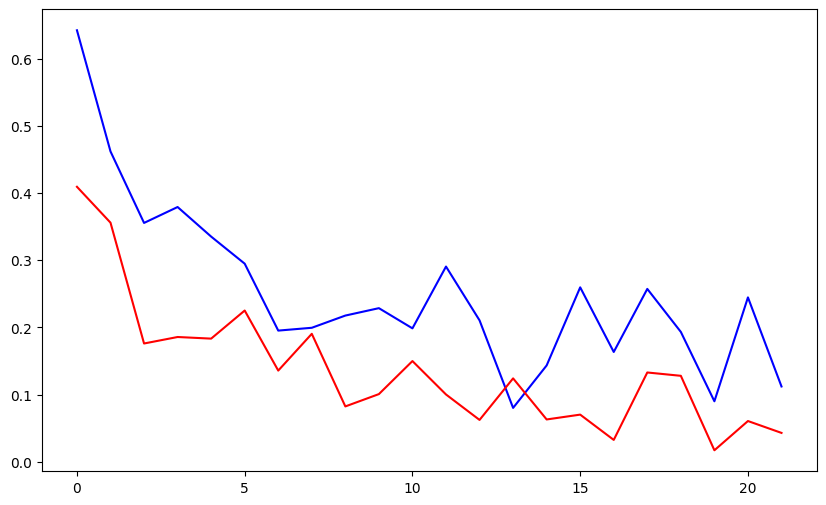

In [22]:
with torch.inference_mode():
    plt.figure(figsize = (10,6))
    plt.plot(torch.tensor(train_losses).cpu(), c = 'b')
    plt.plot(torch.tensor(test_losses).cpu(), c = 'r')

In [20]:
!pip install vector-quantize-pytorch

In [ ]:
from vector_quantize_pytorch import ResidualVQ